# 03. Further Data Exploration and Developing a High Level Modeling Strategy

Before we start further modeling and development of the agent based model, it makes sense to evaluate the available data to see what strategies and options makes most sense to pursue.

In [1]:
# import statements
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# Load the data
data= pd.read_feather('/home/hcekne/data/online_retail_ii/fullDataSet.feather')
training_data = pd.read_feather('/home/hcekne/data/online_retail_ii/training_data.feather')
calibration_data = pd.read_feather('/home/hcekne/data/online_retail_ii/calibration_data.feather')
validation_data = pd.read_feather('/home/hcekne/data/online_retail_ii/validation_data.feather')

### Timeline of sales

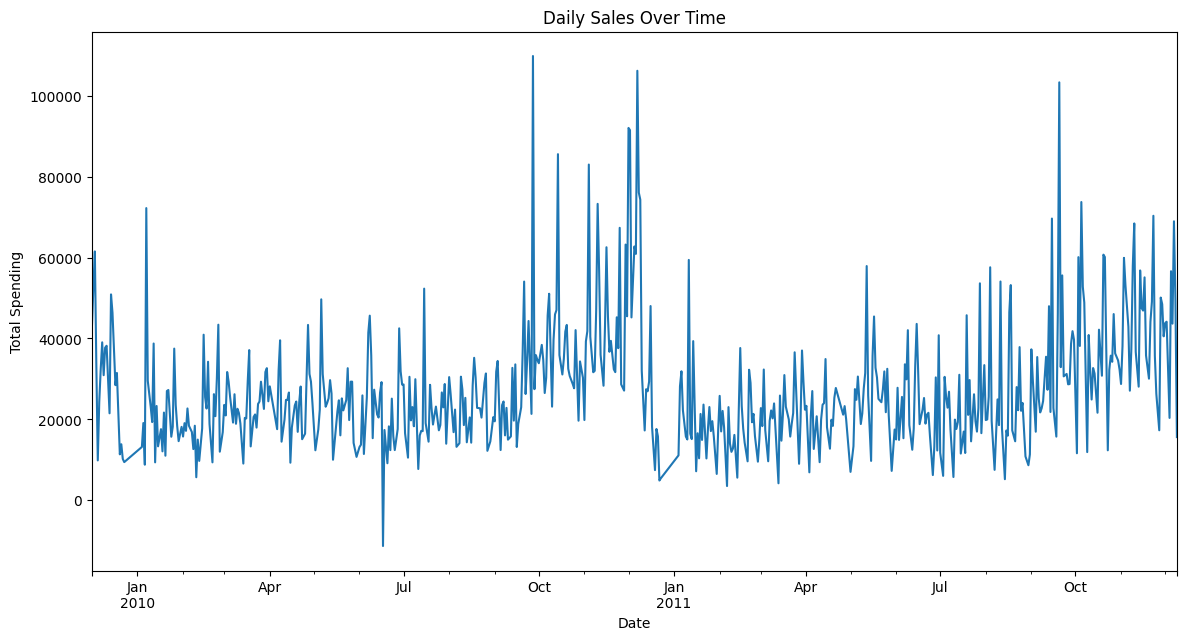

In [3]:
# Group by InvoiceDate and sum the total sales for each day
daily_sales = data.groupby(data['InvoiceDate'])['TotalSpending'].sum()

# Plotting
plt.figure(figsize=(14, 7))
daily_sales.plot(title="Daily Sales Over Time")
plt.ylabel('Total Spending')
plt.xlabel('Date')
plt.show()

Based our intial observation of the data, it looks like we have some temporal patterns in the data that we need to capture. Especially some seasonality around end of year. For our train-test split then we don't just randomly sample observations for test and train but we exclude the last part of the dataset to make sure we are able to learn the seasonality.

### Before developing the agent based model, there are a few fundamental things about agent behaviour that we need to model. First, we need to understand shopping frequency, divided amongst new customers and repeating customers. Then we need to understand shopping baskets, again both for new customers and repeat customers. Once we have evaluated the data and created a strategy for how to model these concepts we can start to run the build the agent based model.

# Customer Shopping Frequency

## New customers

## 01. Calculating base growth rates

In [4]:
# Sort the data by 'InvoiceDate'
training_data_sorted = training_data.sort_values('InvoiceDate')
# Drop duplicates to retain only the first appearance (purchase) of each customer
first_purchase_data = training_data_sorted.drop_duplicates(subset='Customer ID', keep='first').reset_index()
first_purchase_data.drop(columns=['Invoice', 'StockCode', 'Description','Quantity', 'Price','index'], inplace=True)
first_purchase_data['InvoiceDate']
# Calculate the number of new customers each month
new_customers_per_month = first_purchase_data.groupby('YearMonth').size()
# Compute the growth rate
growth_rates = new_customers_per_month.pct_change().dropna()
growth_rates.mean()

-0.06562496090704593

Looking at monthly growth rates for customers gives us an average growth rate of -6.5%. This means that on average the number of new customers shopping every month would fall by about 6.5% from the last month. For our simulations this can serve as a useful starting point and we can recalculate, on a simulation by simulation basis as we run experiments.


In [5]:
# Calculate daily new customers count
daily_new_customers = first_purchase_data.groupby('InvoiceDate').agg({'Customer ID': 'nunique'})

In [6]:
### Plotting the data

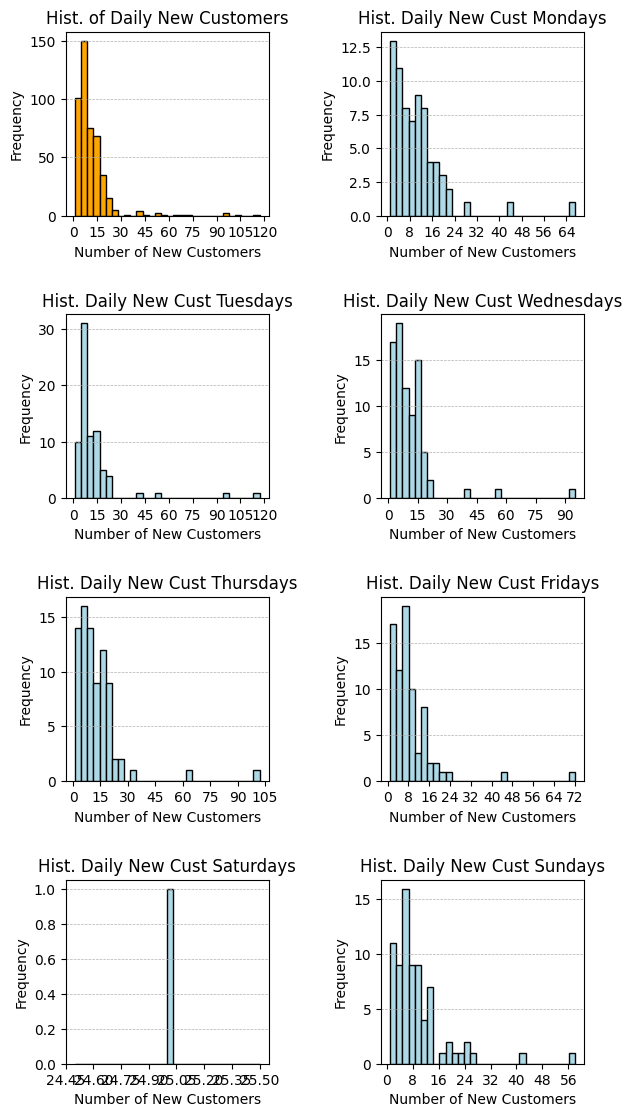

In [7]:
# Setting up the subplots
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(7, 12))
fig.tight_layout(pad=5)

# General Histogram of daily new customers
axes[0, 0].hist(daily_new_customers['Customer ID'], bins=30, color='orange', edgecolor='black')
axes[0, 0].set_title('Hist. of Daily New Customers')
axes[0, 0].set_xlabel('Number of New Customers')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', linestyle='--', linewidth=0.5)
axes[0, 0].xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Histograms of daily new customers split by days of the week
days_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for i, (ax, day) in enumerate(zip(axes.ravel()[1:], days_of_week), 1):
    ax.hist(daily_new_customers[daily_new_customers.index.dayofweek == i-1]['Customer ID'], bins=30, color='lightblue', edgecolor='black')
    ax.set_title(f'Hist. Daily New Cust {day}s')
    ax.set_xlabel('Number of New Customers')
    ax.set_ylabel('Frequency')
    ax.grid(axis='y', linestyle='--', linewidth=0.5)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Remove unused subplots
#axes[3, 1].axis('off')

plt.show()

In [8]:
# Generating the date range
date_range = pd.date_range(start=str(training_data['InvoiceDate'].min()), end=str(training_data['InvoiceDate'].max()))
# Creating a DataFrame with the date range
date_df = pd.DataFrame(date_range, columns=['Date'])
date_df.head()  # Displaying the first few rows for a quick view

,Date
0,2009-12-01
1,2009-12-02
2,2009-12-03
3,2009-12-04
4,2009-12-05


In [9]:
daily_new_customers = daily_new_customers.reset_index()

In [10]:
daily_new_customers = daily_new_customers.merge(date_df,how='outer', left_on = ['InvoiceDate'], right_on=['Date'])
daily_new_customers.InvoiceDate.fillna(daily_new_customers.Date, inplace=True)
daily_new_customers.rename({'Customer ID': 'newCustomerCount'}, axis=1, inplace=True)
daily_new_customers.newCustomerCount.fillna(0, inplace=True)
daily_new_customers.drop(columns=['Date'], axis=1, inplace=True)
daily_new_customers['InvoiceDatetime']  = daily_new_customers['InvoiceDate'].apply(lambda x: pd.to_datetime(str(x)))
daily_new_customers.drop(['InvoiceDate'], axis =1, inplace=True)

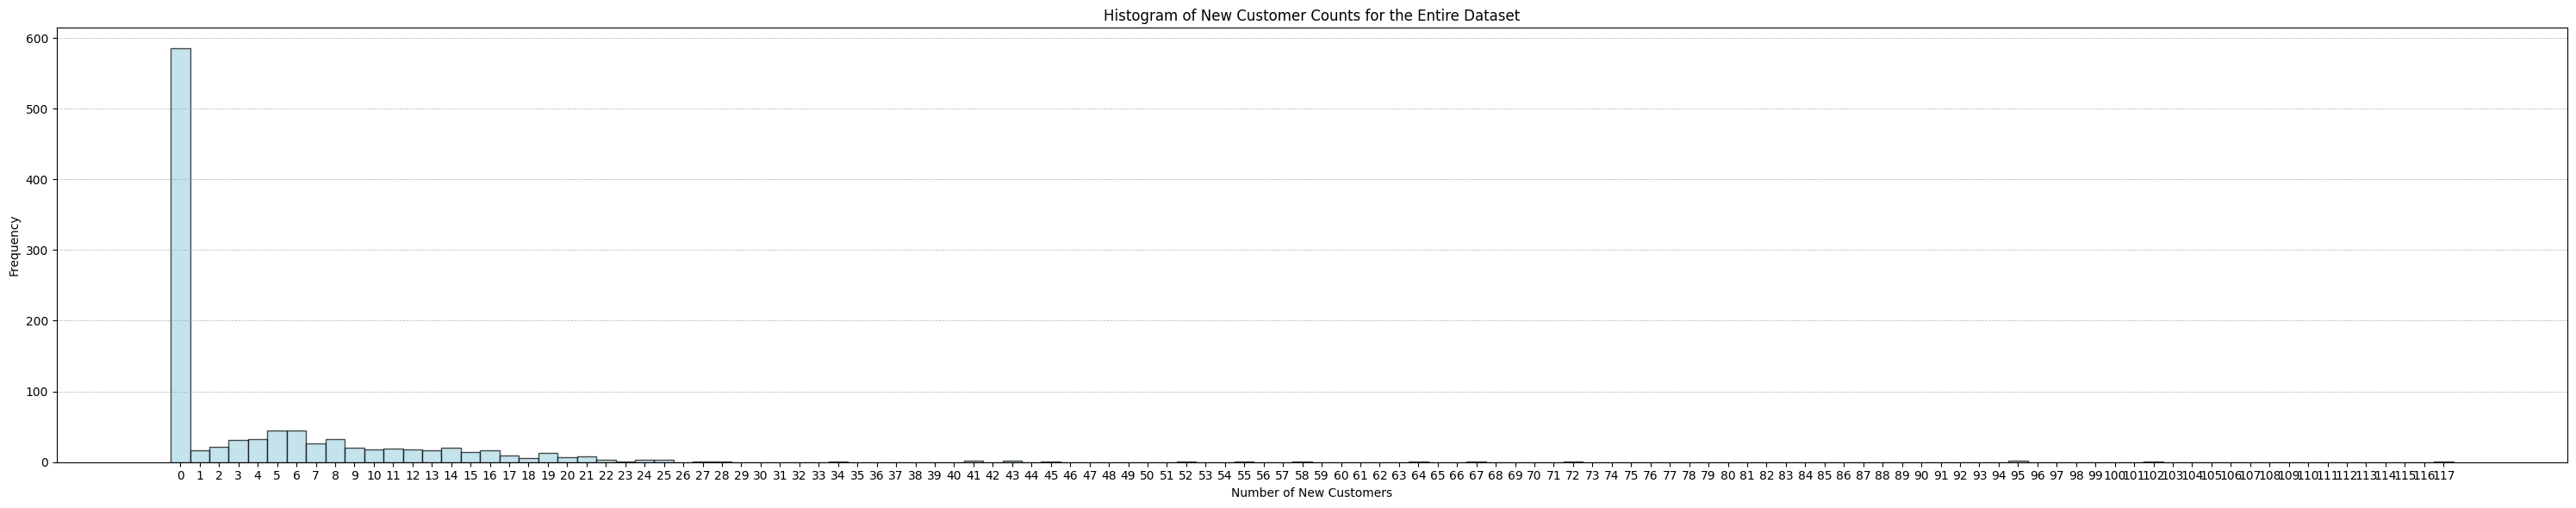

In [11]:
# Plotting histogram for new customer counts for the entire dataset
plt.figure(figsize=(30, 6))
plt.hist(daily_new_customers['newCustomerCount'], bins=range(int(daily_new_customers['newCustomerCount'].max() + 2)), align='left', alpha=0.7, color='lightblue', edgecolor='black')
plt.title('Histogram of New Customer Counts for the Entire Dataset')
plt.xlabel('Number of New Customers')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.xticks(list(range(int(daily_new_customers['newCustomerCount'].max()) + 1)))
plt.tight_layout()
plt.show()

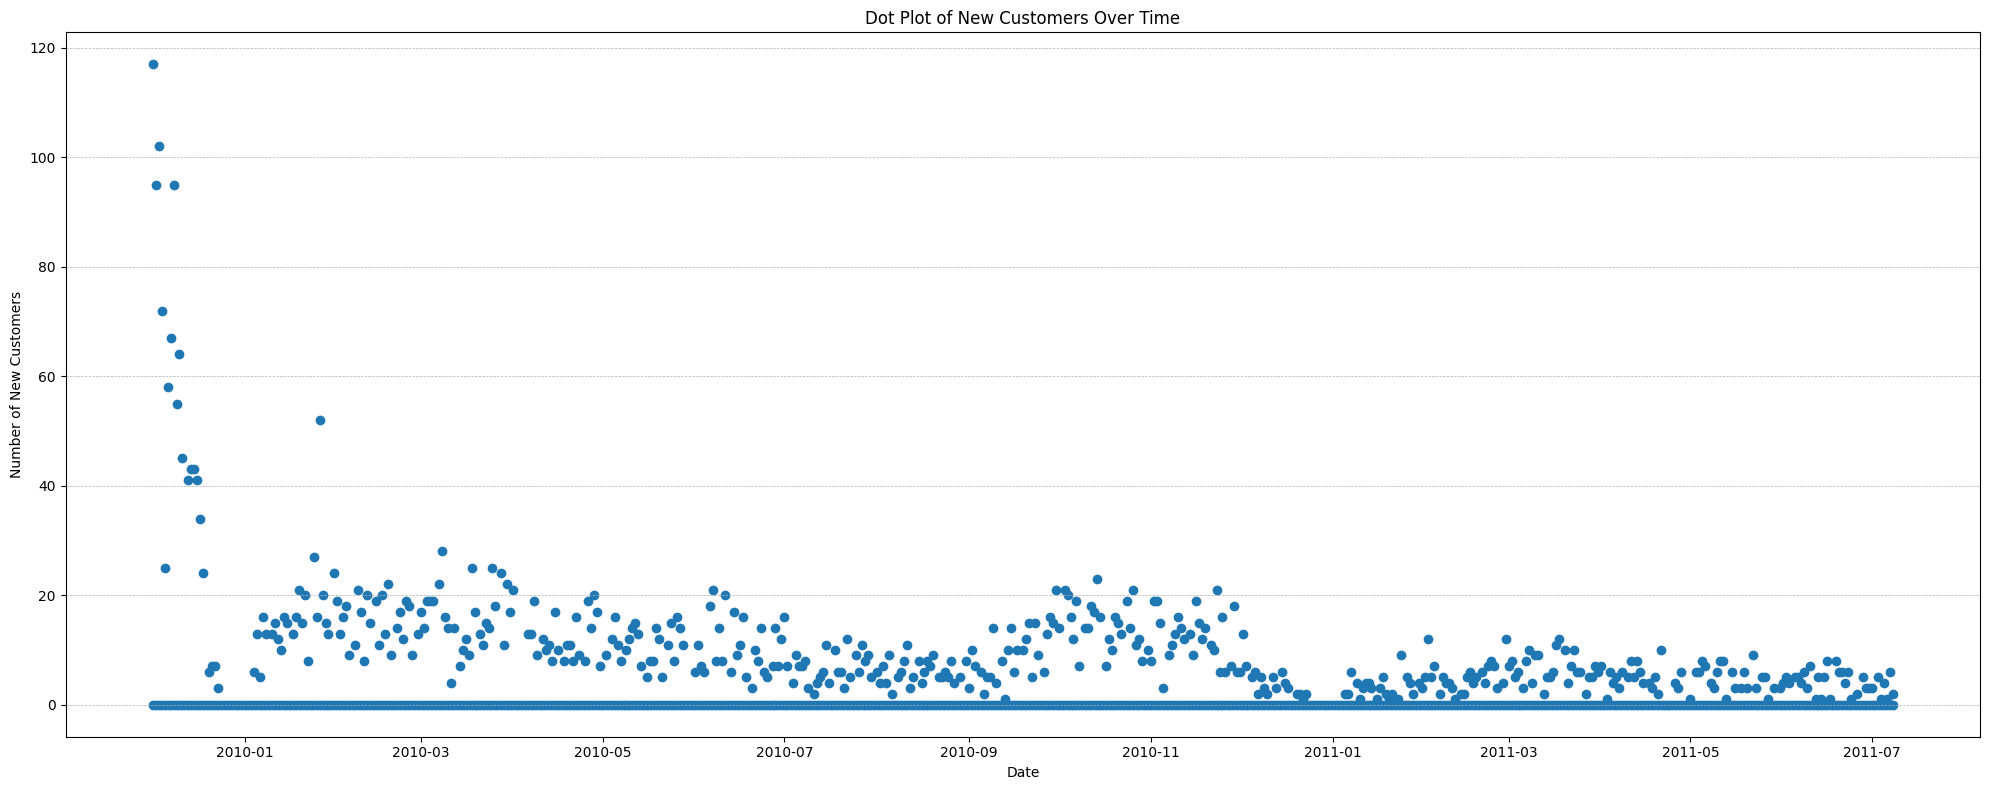

In [12]:
# Dot plot of new customers over time
plt.figure(figsize=(20, 8))
plt.scatter(daily_new_customers['InvoiceDatetime'], daily_new_customers['newCustomerCount'], marker='o')
plt.title('Dot Plot of New Customers Over Time')
plt.xlabel('Date')
plt.ylabel('Number of New Customers')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Finding 1:

This data seems like a decent sample to do 'event' sampling on. But because of how we defined 'new' customer Lets exclude the first 3 months of data (because all customers would seem to be new even if they were repeat customers.)

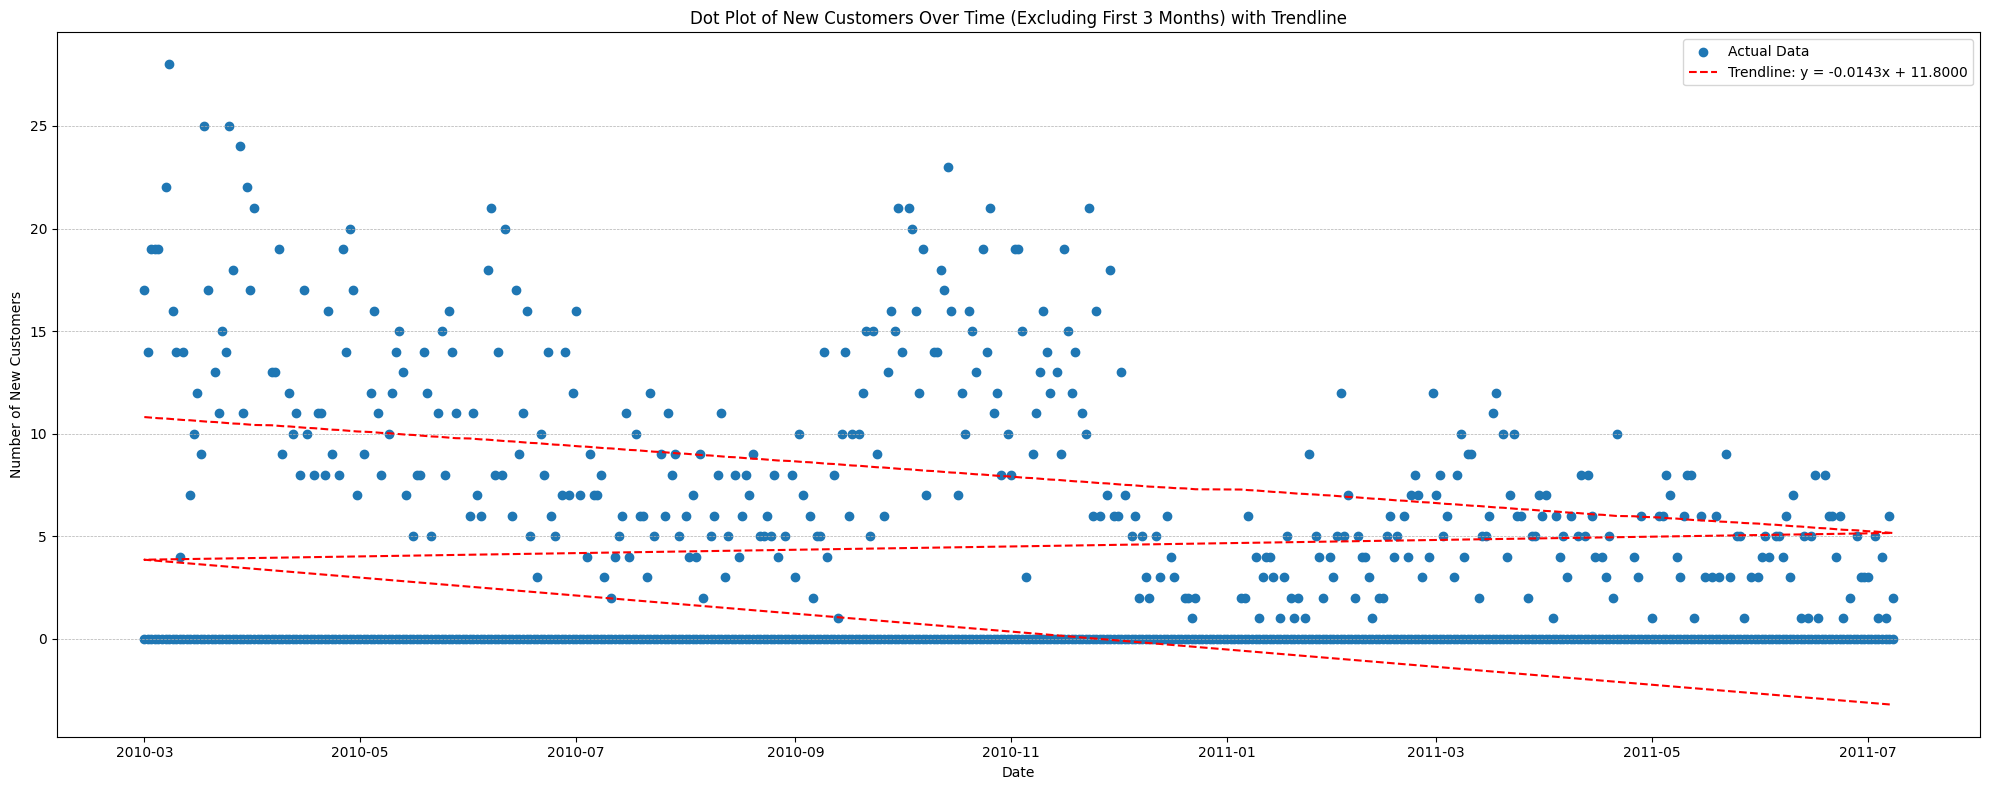

In [13]:

# Exclude the first three months of data
start_date = daily_new_customers['InvoiceDatetime'].min() + pd.DateOffset(months=3)
filtered_data = daily_new_customers[daily_new_customers['InvoiceDatetime'] >= start_date]

# Fit a trendline
z = np.polyfit(filtered_data.index, filtered_data['newCustomerCount'], 1)
p = np.poly1d(z)

# Plot the data and the trendline
plt.figure(figsize=(20, 8))
plt.scatter(filtered_data['InvoiceDatetime'], filtered_data['newCustomerCount'], marker='o', label='Actual Data')
plt.plot(filtered_data['InvoiceDatetime'], p(filtered_data.index), "r--", label=f'Trendline: y = {z[0]:.4f}x + {z[1]:.4f}')
plt.title('Dot Plot of New Customers Over Time (Excluding First 3 Months) with Trendline')
plt.xlabel('Date')
plt.ylabel('Number of New Customers')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# so lets just sample from this distribution with the daily growth factor given by the slope of the trendline.

# Exclude the first 3 months of data
filtered_data = daily_new_customers[90:].copy()

# Represent dates numerically: number of days since the start
filtered_data['DaysSinceStart'] = range(len(filtered_data))

# Set X and Y for regression
X = filtered_data['DaysSinceStart']
y = filtered_data['newCustomerCount']

# Prepare data for scikit-learn linear regression
X = filtered_data['DaysSinceStart'].values.reshape(-1, 1)
y = filtered_data['newCustomerCount'].values

# Initialize linear regression model
lr = LinearRegression()

# Fit the model to the data
lr.fit(X, y)

# Extract the slope (coefficient of DaysSinceStart)
slope_sklearn = lr.coef_[0]
slope_sklearn

-0.01332684415890208

## Finding 2:

We can event sample the new customer growth rates and apply a growth factor of -1.33%

## Repeat Shopping from Existing Customers

The easiest and most naive way - not to say it would be bad - would be to average out the duration for each of the customers and then sample from that. So for example if a customer had an average duration between shops of 10 days then on average his probability of shopping on any given day would be 1/10 and then if we sample a random number between 0 and 1 and if that number is <0.1 we have a shop event for the customer.  The problem with this approach would be that we would recalculate the customers average duration and it is very sensitive to early random fluctuations. If we were to run this as an experiment we could initalize an array to represent a typical shopper average and then see how that would perform.

In addition we want to somehow model in seasonality. There are again a few differnt ways to do this. 

1. We could have the agents' mean duration betwwen shops be depenedent on the month. So some months would increase and others would decrease it. This would lead to an increase of shops around certain times of the year. --> This is the approach we are going with
2. We could augment the agent average by a general population trend. This could be normalized so the overal impact on the probability of a shop would be 0 but higher in some months and lower in others.

We also tried some survival analysis models with weak results. 

Your idea of considering the "duration until censoring" as a variable is excellent, and it can give you valuable insights into customer behavior. For one-time shoppers, the longer the "duration until censoring," the more likely they are to be genuine one-time shoppers as opposed to new repeat customers for whom we just don't have enough data yet.

---

Here's how you can incorporate this into your simulations:

### For One-Time Shoppers:

1. **Identify One-Time Shoppers**: Identify customers who have only one shopping event in your dataset.
  
2. **Calculate Duration Until Censoring**: For these one-time shoppers, calculate the duration from their single shopping event until the end of the dataset (the censoring event).

3. **Categorization**: 
  - If `durationUntilCensoring` is above a certain high threshold, you can be fairly confident that they are true one-time shoppers. Exclude them from the simulation of repeat shopping.
  - If `durationUntilCensoring` is below that threshold, you may want to include them but with a high average duration (as in a very low likelihood to shop again soon).

### For All Shoppers:

- **Calculate Duration Until Censoring**: Calculate this duration for all shoppers, not just the one-time shoppers.

- **Update Probabilities**: Use this duration to update the probability of shopping again. For example, if a regular customer suddenly has a long `durationUntilCensoring`, you may want to adjust their probability downwards.

Here's a simple formulaic way to incorporate `durationUntilCensoring`:

\[
\text{Adjusted Average Duration} = \frac{\text{Original Average Duration} \times (N - 1) + \text{Duration Until Censoring}}{N}
\]

Where \(N\) is the number of shopping events for that customer. This is a form of weighted average where the `durationUntilCensoring` is treated as an additional data point.

---

Setting the churn threshold at 0.9 sounds like a good starting point for your simulations. You can indeed experiment later to see how sensitive your model outcomes are to changes in this parameter.

With this final piece in place, your agent-based model would now have a number of features to simulate customer behavior:

1. **Basic Shopping Probability**: Determined by the average duration between shops for each customer.
2. **Seasonal Modifiers**: To account for changes in shopping frequency based on the time of year.
3. **One-Time Shopper Classification**: For customers with only one recorded shopping event.
4. **Churn Score**: To flag customers who are likely to have 'churned' and therefore should not be considered in future simulations.



In [15]:
training_data['Year'] = training_data['InvoiceDatetime'].dt.year
training_data['Month'] = training_data['InvoiceDatetime'].dt.month

In [16]:
# Seasonality can be found with the following:
# Group data by Customer ID, InvoiceDate and compute aggregated features 
data_grouped_year_month = training_data.groupby(['Year', 'Month']).agg({
    'Invoice': 'nunique'
}).reset_index()

data_grouped_year_month.rename(columns={'Invoice': 'NumberOfUniqueSales'}, inplace=True)

In [17]:
# Take the average, but only use complete months, so don't use the last months data. 
data_grouped_year_month = data_grouped_year_month[:-1]
monthly_average_sales = data_grouped_year_month.groupby(['Month']).agg({'NumberOfUniqueSales':'mean'})
monthly_average_sales['NumberOfUniqueSales'].mean()
monthly_average_sales['all_month_average'] = monthly_average_sales['NumberOfUniqueSales'].mean()
monthly_average_sales['scalingFactor'] =  monthly_average_sales['NumberOfUniqueSales']/monthly_average_sales['all_month_average']

## Finding 3: 

Now we have a scaling factor that we can apply to each of the probabilities of shops. Through the year the scaling factor will averager out.

## Finding 4

To calculate the probability of repeat shops we can find:

1. Basic Shopping Probability: Determined by the average duration between shops for each customer.
2. Apply Seasonal Modifiers: To account for changes in shopping frequency based on the time of year.
3. Determine: One-Time Shopper Classification: For customers with only one recorded shopping event.
4. Apply Churn Score: To flag customers who are likely to have 'churned' and therefore should not be considered in future simulations.


In [18]:
# Sorting the data by 'Customer ID' and 'InvoiceDatetime'
training_data.sort_values(by=['Customer ID', 'InvoiceDatetime'], inplace=True)

# Resetting the index
training_data.reset_index(drop=True, inplace=True)

# Calculate the time difference between consecutive purchases for the same customer
training_data['Duration'] = training_data.groupby('Customer ID')['InvoiceDatetime'].diff().dt.days

# Censoring time
# This would be the difference between the last purchase date of each customer and the last date in the dataset
last_date_in_data = training_data['InvoiceDatetime'].max()
training_data['DurationUntilCensoring'] = last_date_in_data - training_data.groupby('Customer ID')['InvoiceDatetime'].transform('max')
training_data['DurationUntilCensoring'] = training_data['DurationUntilCensoring'].dt.days

# Average duration between shops for each customer
average_duration = training_data.groupby('Customer ID')['Duration'].mean().reset_index()
average_duration.columns = ['Customer ID', 'AvgDuration']

# Number of shops for each customer
num_shops = training_data.groupby('Customer ID')['Invoice'].nunique().reset_index()
num_shops.columns = ['Customer ID', 'NumShops']

# Merge average duration and number of shops into a single DataFrame
customer_info = pd.merge(average_duration, num_shops, on='Customer ID')

# Add DurationUntilCensoring
last_shop_info = training_data.groupby('Customer ID')['DurationUntilCensoring'].first().reset_index()
customer_info = pd.merge(customer_info, last_shop_info, on='Customer ID')

customer_info.head()

,Customer ID,AvgDuration,NumShops,DurationUntilCensoring
0,12347.0,1.273256,5,29
1,12348.0,4.021277,4,94
2,12349.0,3.075472,4,253
3,12350.0,0.000000,1,156
4,12351.0,0.000000,1,221


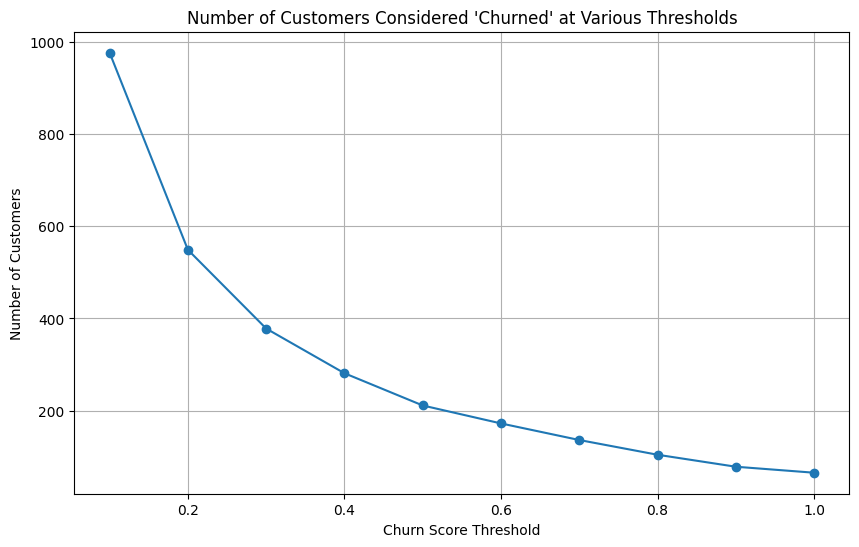

In [19]:
# Calculate the churn score for each customer
customer_info['ChurnScore'] = customer_info['AvgDuration'] / (customer_info['AvgDuration'] + customer_info['DurationUntilCensoring'])

# Create a function to plot the number of customers considered 'churned' at various thresholds
def plot_churned_customers_at_thresholds(churn_scores, thresholds):
    import matplotlib.pyplot as plt
    counts = [sum(churn_scores >= thresh) for thresh in thresholds]
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, counts, marker='o')
    plt.title("Number of Customers Considered 'Churned' at Various Thresholds")
    plt.xlabel("Churn Score Threshold")
    plt.ylabel("Number of Customers")
    plt.grid(True)
    plt.show()

# Define a range of thresholds to explore
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Plot the number of customers that would be considered 'churned' at these thresholds
plot_churned_customers_at_thresholds(customer_info['ChurnScore'], thresholds)


In [20]:
# Group data by Customer ID, InvoiceDate and compute aggregated features 
data_grouped = training_data.groupby(['Customer ID', 'InvoiceDate']).agg({
    'TotalSpending': 'sum',
    'StockCode': 'nunique',
    'Quantity': 'sum'
}).reset_index()


data_grouped['InvoiceDate'] = data_grouped['InvoiceDate'].dt.to_timestamp()

data_grouped.rename(columns={'StockCode': 'NumberOfUniqueProducts'}, inplace=True)

# Sort data by Customer ID and InvoiceDate for proper computation of next purchase date
data_grouped_sorted = data_grouped.sort_values(['Customer ID', 'InvoiceDate'])

# Calculate the difference in days between consecutive purchases for each customer
data_grouped_sorted['NextPurchaseDate'] = data_grouped_sorted.groupby('Customer ID')['InvoiceDate'].shift(-1)

data_grouped_sorted['Duration'] = (data_grouped_sorted['NextPurchaseDate'] - data_grouped_sorted['InvoiceDate']).dt.days

# Define the 'Event' column
data_grouped_sorted['Event'] = data_grouped_sorted['Duration'].notna().astype(int)

# Drop the NextPurchaseDate column for cleanliness
data_grouped_sorted.drop(columns=['NextPurchaseDate'], inplace=True)

data_grouped_sorted.head()


data_customer_grouped = data_grouped_sorted.groupby(['Customer ID']).agg({
    'Duration' : 'mean', 
    'Event': 'sum', 
    'NumberOfUniqueProducts' : 'mean',
    'TotalSpending' : 'mean'
}).reset_index()

data_customer_grouped.rename(columns={'Duration': 'avgDuration', 'Event' : 'countEvents', 'NumberOfUniqueProducts': 'avgUniqueProds', 'TotalSpending': 'avgSpending'}, inplace=True)

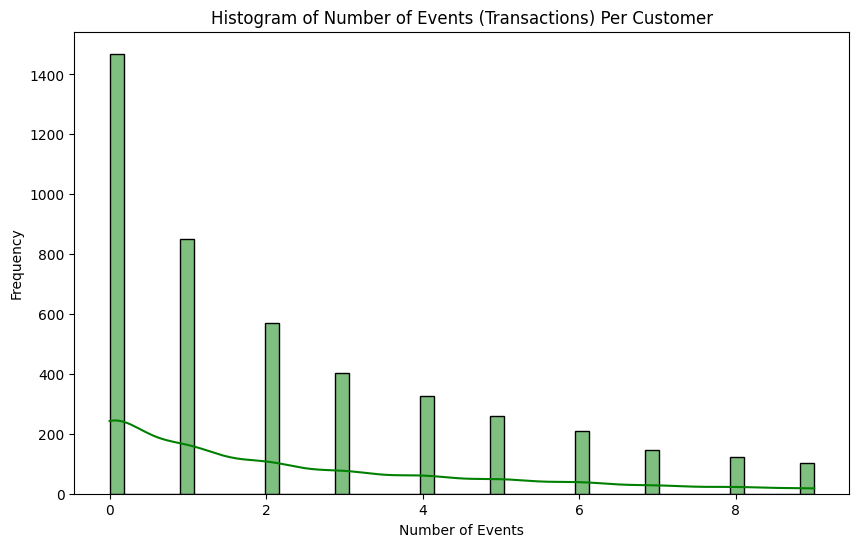

In [21]:
# Plot 2: Histogram of Number of Events (Transactions) Per Customer
plt.figure(figsize=(10, 6))
sns.histplot(data_customer_grouped[data_customer_grouped['countEvents']<10]['countEvents'], bins=50, kde=True, color='green')
plt.title('Histogram of Number of Events (Transactions) Per Customer')
plt.xlabel('Number of Events')
plt.ylabel('Frequency')
plt.show()

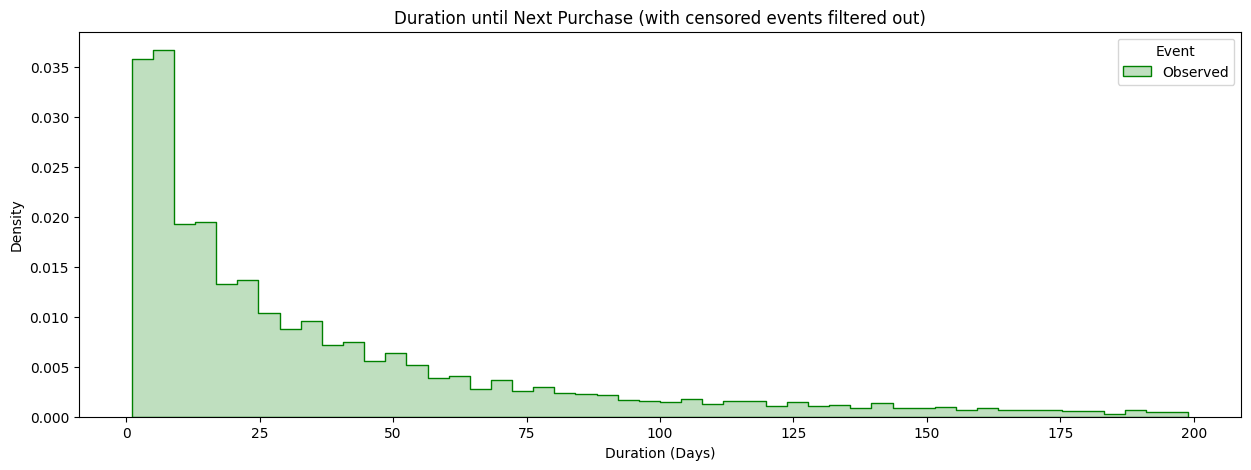

In [22]:
# Plotting the duration again with corrected color coding
plt.figure(figsize=(15, 5))
sns.histplot(data=data_grouped_sorted[data_grouped_sorted['Duration']<200], x="Duration", hue="Event", bins=50, palette={0: 'red', 1: 'green'}, element="step", stat="density")
plt.xlabel("Duration (Days)")
plt.ylabel("Density")
plt.title("Duration until Next Purchase (with censored events filtered out)")
plt.legend(title="Event", labels=["Observed", "Censored"], loc="upper right")
plt.show()

We clearly see that for around 80% of customers the average duration between shops is less than 117 days and for 90% of customers it is less than 168 days, in addition we have all the 1 time shoppers who only shop once. 

We probably want to have a special function for one-time shoppers that basically determines the probability of a shop given the duration since first shop. We can construct a dataset were we have the duration between first and second shop for repeat shoppers and the duration until censor for the one time shoppers.

In [23]:
data_customer_grouped['binnedAvgDuration'] = pd.qcut(data_customer_grouped['avgDuration'], q=10)

In [24]:
data_customer_grouped.groupby(['binnedAvgDuration']).agg({'Customer ID':'count'})

,Customer ID
binnedAvgDuration,
"(0.999, 16.0]",368
"(16.0, 26.5]",365
"(26.5, 36.0]",367
"(36.0, 46.083]",364
"(46.083, 57.707]",365
"(57.707, 71.309]",366
"(71.309, 89.5]",366
"(89.5, 117.6]",365
"(117.6, 168.0]",367


# Customer Shopping Basket

## Size of the basket: How many unique products will they likely buy?

### First time buyers

In [37]:
# Sort the data by 'InvoiceDate'
# training_data_sorted = training_data.sort_values('InvoiceDate')
# Drop duplicates to retain only the first appearance (purchase) of each customer
# first_purchase_data = training_data_sorted.drop_duplicates(subset='Customer ID', keep='first').reset_index()

In [38]:
first_purchase_data

,InvoiceDatetime,Customer ID,Country,TotalSpending,PriceCategory,YearMonth,InvoiceDate,Weekday
0,2009-12-01 07:45:00,13085.0,United Kingdom,83.399994,Very Low,2009-12,2009-12-01,Tuesday
1,2009-12-01 13:31:00,13097.0,United Kingdom,14.750000,Very Low,2009-12,2009-12-01,Tuesday
2,2009-12-01 13:37:00,13590.0,United Kingdom,18.240000,Very Low,2009-12,2009-12-01,Tuesday
3,2009-12-01 13:29:00,17611.0,United Kingdom,14.849999,Very Low,2009-12,2009-12-01,Tuesday
4,2009-12-01 13:29:00,15051.0,United Kingdom,5.040000,Very Low,2009-12,2009-12-01,Tuesday
...,...,...,...,...,...,...,...,...
5122,2011-07-07 12:56:00,17892.0,United Kingdom,1.900000,Very Low,2011-07,2011-07-07,Thursday
5123,2011-07-07 13:33:00,15505.0,United Kingdom,15.000000,Very Low,2011-07,2011-07-07,Thursday
5124,2011-07-07 12:39:00,16929.0,United Kingdom,13.200001,Very Low,2011-07,2011-07-07,Thursday
5125,2011-07-08 10:23:00,12461.0,Switzerland,14.849999,Very Low,2011-07,2011-07-08,Friday


In [60]:
customer_basket_data = training_data.groupby(['Customer ID', 'Invoice', 'InvoiceDatetime']).agg({'StockCode':'nunique', 'TotalSpending':'sum'}).reset_index()

In [61]:
customer_basket_data.sort_values(['Customer ID', 'InvoiceDatetime'], inplace=True)

In [62]:
customer_basket_data.rename({'StockCode':'countUniqueProducts'}, axis=1, inplace=True)

In [64]:
customer_basket_data['Shop Order'] = customer_basket_data.groupby('Customer ID').cumcount() + 1

In [65]:
customer_basket_data

,Customer ID,Invoice,InvoiceDatetime,countUniqueProducts,TotalSpending,Shop Order
0,12347.0,529924,2010-10-31 14:20:00,40,611.530029,1
1,12347.0,537626,2010-12-07 14:57:00,31,1423.579956,2
2,12347.0,542237,2011-01-26 14:30:00,29,475.390015,3
3,12347.0,549222,2011-04-07 10:43:00,24,636.250000,4
4,12347.0,556201,2011-06-09 13:01:00,18,382.519989,5
...,...,...,...,...,...,...
33846,18287.0,508581,2010-05-17 11:55:00,54,1071.609985,2
33847,18287.0,523289,2010-09-21 12:17:00,19,862.000000,3
33848,18287.0,523290,2010-09-21 12:19:00,2,30.599998,4
33849,18287.0,534346,2010-11-22 11:51:00,10,381.500000,5


In [67]:
customer_basket_data['first_shopping_event'] =  ~customer_basket_data['Customer ID'].duplicated(keep='first')

In [69]:
customer_basket_data[customer_basket_data['Shop Order'] <11].groupby(['Shop Order']).agg({'countUniqueProducts':'mean'})

,countUniqueProducts
Shop Order,
1,22.367076
2,16.135661
3,16.462793
4,16.358577
5,16.177778
6,16.215802
7,16.151367
8,16.433058
9,16.886233


In [45]:
customer_basket_data

,Customer ID,Invoice,InvoiceDatetime,countUniqueProducts,TotalSpending,first_shopping_event
0,12347.0,529924,2010-10-31 14:20:00,40,611.530029,True
1,12347.0,537626,2010-12-07 14:57:00,31,1423.579956,False
2,12347.0,542237,2011-01-26 14:30:00,29,475.390015,False
3,12347.0,549222,2011-04-07 10:43:00,24,636.250000,False
4,12347.0,556201,2011-06-09 13:01:00,18,382.519989,False
...,...,...,...,...,...,...
33846,18287.0,508581,2010-05-17 11:55:00,54,1071.609985,False
33847,18287.0,523289,2010-09-21 12:17:00,19,862.000000,False
33848,18287.0,523290,2010-09-21 12:19:00,2,30.599998,False
33849,18287.0,534346,2010-11-22 11:51:00,10,381.500000,False


In [55]:
data=customer_basket_data[(customer_basket_data['first_shopping_event'] == True) & 
             (customer_basket_data['countUniqueProducts'] == 1)]

In [56]:
data

,Customer ID,Invoice,InvoiceDatetime,countUniqueProducts,TotalSpending,first_shopping_event
63,12362.0,489447,2009-12-01 10:10:00,1,130.000000,True
116,12382.0,C495743,2010-01-26 16:25:00,1,-18.379999,True
179,12404.0,495742,2010-01-26 16:25:00,1,63.240002,True
379,12435.0,489831,2009-12-02 13:58:00,1,1007.999939,True
454,12454.0,C495738,2010-01-26 16:24:00,1,-26.250000,True
...,...,...,...,...,...,...
33627,18233.0,541426,2011-01-18 08:44:00,1,440.000000,True
33683,18246.0,503988,2010-04-09 10:19:00,1,162.720001,True
33708,18252.0,C490995,2009-12-08 17:16:00,1,-76.500000,True
33802,18273.0,506229,2010-04-28 12:24:00,1,153.000000,True


In [86]:
customer_basket_data['mod8CountProducts'] = customer_basket_data['countUniqueProducts'].apply(lambda x: x%8)

In [101]:
customer_basket_data[(customer_basket_data['countUniqueProducts'] !=1 ) & (customer_basket_data['mod8CountProducts']==1)]

,Customer ID,Invoice,InvoiceDatetime,countUniqueProducts,TotalSpending,Shop Order,first_shopping_event,mod8CountProducts
13,12350.0,543037,2011-02-02 16:01:00,17,334.399994,1,True,1
32,12356.0,534804,2010-11-24 12:24:00,25,349.850006,3,False,1
37,12358.0,490751,2009-12-08 07:59:00,17,1429.829956,1,True,1
38,12358.0,511229,2010-06-07 12:28:00,17,268.100006,2,False,1
74,12369.0,500367,2010-03-08 08:09:00,9,348.320007,1,True,1
...,...,...,...,...,...,...,...,...
33798,18272.0,549185,2011-04-07 09:35:00,33,639.820007,5,False,1
33804,18275.0,490971,2009-12-08 16:23:00,9,372.640015,1,True,1
33810,18276.0,532427,2010-11-12 10:11:00,17,330.829987,6,False,1
33833,18283.0,540350,2011-01-06 14:14:00,57,108.449997,7,False,1


In [ ]:
## We could sample from this historic size..

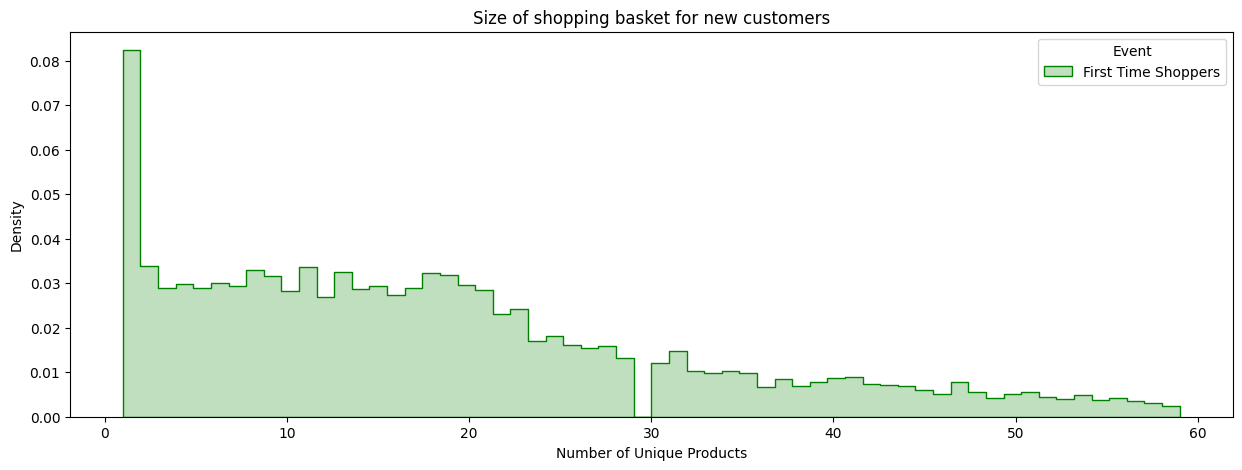

In [104]:
# Plotting the duration again with corrected color coding
plt.figure(figsize=(15, 5))
sns.histplot(data=customer_basket_data[(customer_basket_data['first_shopping_event'] == True) & 
             (customer_basket_data['countUniqueProducts'] < 60)], 
             x="countUniqueProducts", hue="first_shopping_event", bins=60, palette={False: 'red', True: 'green'}, element="step", stat="density")
plt.xlabel("Number of Unique Products")
plt.ylabel("Density")
plt.title("Size of shopping basket for new customers")
plt.legend(title="Event", labels=["First Time Shoppers", "Repeat Shoppers"], loc="upper right")
plt.show()

### Repeat Buyers

In [ ]:
## How strong of a predictor is previous shopping basket???

Ah, if the distribution of shopping basket sizes is highly skewed, then the standard deviation might not be a good measure of spread, and the mean might not be a good measure of central tendency for the general population or for individual customers.

Here are some alternative approaches:

## Sampling from the Whole Historic Distribution
If you simply sample from the whole distribution of historical basket sizes, you could capture the skewness and long tail. However, this approach wouldn't take into account any customer-specific behaviors.

## Using Non-Parametric Methods
Instead of assuming a Gaussian distribution, you could use Kernel Density Estimation (KDE) to estimate the probability density function of the basket sizes. This way, you can capture the skewness and the long tail of the distribution. You could then sample from this estimated distribution.

## Using Customer Embeddings
If you want to link this to customer embeddings, one approach could be to train a regression model where the input features are the customer embeddings and the target variable is the shopping basket size. The model could then predict the most likely basket size for a new or existing customer based on their embedding.

---
---

## We choose option Sampling from the Whole Historic Distribution since the others are slightly more involved.

In [ ]:
## For repeat buyers we can utilize a more individualized approach.

## For customers with between 1 and 10 historic shops we calculate a weighted average of their historic shopping size average together with the shopping size of the general population. 

## We then calcaluate a measure of variance based on the population variance and create an interval to sample from using the standard deviation of the underlying data and this.

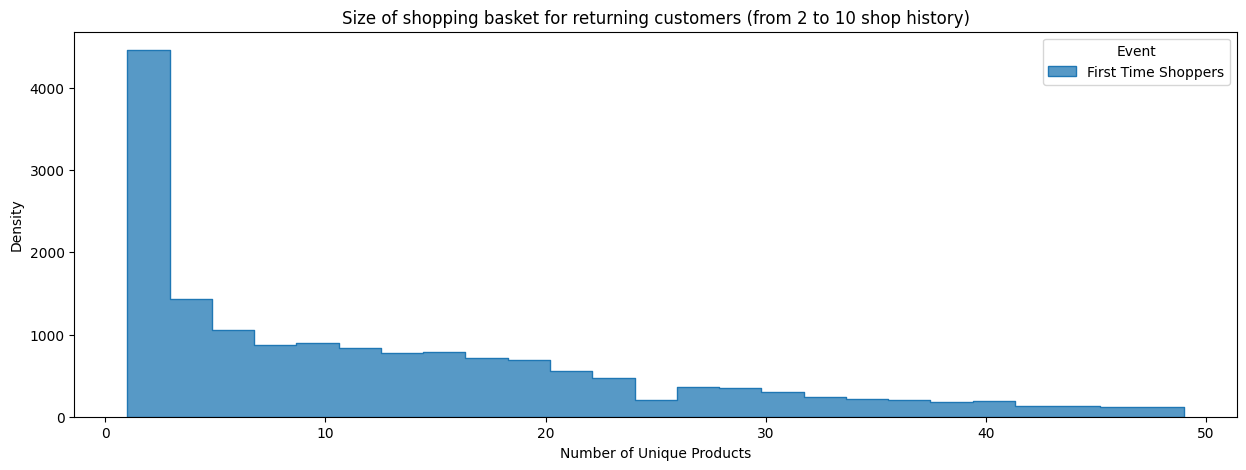

In [73]:
# Plotting the duration again with corrected color coding
plt.figure(figsize=(15, 5))
sns.histplot(data=customer_basket_data[(customer_basket_data['Shop Order'] >1) & (customer_basket_data['Shop Order'] <11) & (customer_basket_data['countUniqueProducts'] <50)  ], x="countUniqueProducts", bins=25, element="step", stat="count")
plt.xlabel("Number of Unique Products")
plt.ylabel("Density")
plt.title("Size of shopping basket for returning customers (from 2 to 10 shop history)")
plt.legend(title="Event", labels=["First Time Shoppers", "Repeat Shoppers"], loc="upper right")
plt.show()

In [ ]:
## This seems very skewed.. perhaps we can use the embeddings to predict the number of products?

In [77]:
one_time_shoppers_list = customer_basket_data[customer_basket_data['countUniqueProducts']==1]['Customer ID'].unique()

In [78]:
one_time_customer_basket_data = customer_basket_data[customer_basket_data['Customer ID'].isin(one_time_shoppers_list)]


In [82]:
one_time_customer_basket_data

,Customer ID,Invoice,InvoiceDatetime,countUniqueProducts,TotalSpending,Shop Order,first_shopping_event
12,12349.0,C490283,2009-12-04 12:49:00,5,-24.150000,1,True
9,12349.0,506394,2010-04-29 13:20:00,46,1068.520020,2,False
10,12349.0,508728,2010-05-18 09:57:00,1,200.000000,3,False
11,12349.0,529344,2010-10-28 08:23:00,55,1402.619995,4,False
15,12352.0,532430,2010-11-12 10:20:00,6,143.750000,1,True
...,...,...,...,...,...,...,...
33846,18287.0,508581,2010-05-17 11:55:00,54,1071.609985,2,False
33847,18287.0,523289,2010-09-21 12:17:00,19,862.000000,3,False
33848,18287.0,523290,2010-09-21 12:19:00,2,30.599998,4,False
33849,18287.0,534346,2010-11-22 11:51:00,10,381.500000,5,False


In [83]:
training_data[training_data['Invoice']=='508728']

,Invoice,StockCode,Description,Quantity,InvoiceDatetime,Price,Customer ID,Country,TotalSpending,PriceCategory,YearMonth,InvoiceDate,Weekday,Year,Month,Duration,DurationUntilCensoring
272,508728,POST,POSTAGE,1,2010-05-18 09:57:00,200.0,12349.0,Italy,200.0,High,2010-05,2010-05-18,Tuesday,2010,5,18.0,253


In [ ]:
one_item_shopers = customer_basket_data[]

## Contents of the basket: What products are they likely to buy

Using embeddings to model customer behavior is intriguing and could potentially offer a powerful way to predict future purchases. Embeddings could capture the latent factors
that explain why certain customers are more similar to others based on their purchasing patterns. Here's a general strategy to implement this:

## Exising Customers

## New Customers

### Steps to Create the Embedding Model

1. **Data Preparation**: 
    - Map each `Customer ID` to a unique integer index.
    - Map each `Product ID` to a unique integer index.
    - Create a dataset containing these mapped customer and product indices along with the quantity of each purchase.
    
2. **Model Architecture**:
    - Input Layer: Two input layers, one for the customer index and one for the product index.
    - Embedding Layers: Two embedding layers, one for customer and one for product, which map the indices to dense vectors of fixed size.
    - Merge Layer: Combine the embeddings, possibly with the quantity, using layers like concatenate or multiply.
    - Output Layer: Depending on the task, this could be a regression layer for predicting quantities or a classification layer for predicting categories.
  
3. **Model Training**: 
    - Use a suitable loss function depending on the task (e.g., MSE for regression).
    - Train the model on your dataset.

4. **Evaluation**: 
    - Use the trained model to generate embeddings for customers.
    - Evaluate these embeddings using tasks like clustering or nearest neighbors to see if similar customers are grouped together.
  
5. **Sampling New Customers**: 
    - To sample new customers, you can either sample from the distribution of existing embeddings or generate synthetic embeddings that capture the essential characteristics of your customer base.

6. **Translating Embeddings to Real Space**: 
    - After obtaining a new customer embedding, you can find the nearest existing customer embeddings and look at their purchasing history to recommend products.

### Preparing the Data

Here's how you can prepare the data:

1. Create a mapping from `Customer ID` to a unique integer and another mapping from `Product ID` to a unique integer.
2. Create a new dataframe where these mappings replace the original IDs.
3. The target variable could be the `Quantity` of the product purchased.

---

### How to adapt this logic to account for varying shopping baskets througout the year??

1. Could we have some seasonal index as well? Is there any way to evaluate a triple dot product? or could we train the network yet again but now feed it information? Maybe we could have some sort of scaling parameter of the product embeddings?

In [ ]:
### For seasonal adjustments to the products, could you somehow scale the embeddings with a scaling factor that made them more or less likely based on 

In [33]:
training_data

,Invoice,StockCode,Description,Quantity,InvoiceDatetime,Price,Customer ID,Country,TotalSpending,PriceCategory,YearMonth,InvoiceDate,Weekday,Year,Month,Duration,DurationUntilCensoring
0,529924,22698,PINK REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.700001,Very Low,2010-10,2010-10-31,Sunday,2010,10,NaN,29
1,529924,22699,ROSES REGENCY TEACUP AND SAUCER,6,2010-10-31 14:20:00,2.95,12347.0,Iceland,17.700001,Very Low,2010-10,2010-10-31,Sunday,2010,10,0.0,29
2,529924,20985,HEART CALCULATOR,12,2010-10-31 14:20:00,1.25,12347.0,Iceland,15.000000,Very Low,2010-10,2010-10-31,Sunday,2010,10,0.0,29
3,529924,22418,10 COLOUR SPACEBOY PEN,24,2010-10-31 14:20:00,0.85,12347.0,Iceland,20.400002,Very Low,2010-10,2010-10-31,Sunday,2010,10,0.0,29
4,529924,22422,TOOTHPASTE TUBE PEN,12,2010-10-31 14:20:00,0.65,12347.0,Iceland,7.800000,Very Low,2010-10,2010-10-31,Sunday,2010,10,0.0,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600984,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,36,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,59.399998,Very Low,2011-05,2011-05-22,Sunday,2011,5,0.0,47
600985,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,60,2011-05-22 10:39:00,1.45,18287.0,United Kingdom,87.000000,Very Low,2011-05,2011-05-22,Sunday,2011,5,0.0,47
600986,554065,85039B,S/4 IVORY MINI ROSE CANDLE IN BOWL,12,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,19.799999,Very Low,2011-05,2011-05-22,Sunday,2011,5,0.0,47
600987,554065,85040A,S/4 PINK FLOWER CANDLES IN BOWL,12,2011-05-22 10:39:00,1.65,18287.0,United Kingdom,19.799999,Very Low,2011-05,2011-05-22,Sunday,2011,5,0.0,47


# Customer Shopping Frequency

# Customer Shopping Frequency